Author: Hariz Mohd Rani Hisham

In [1]:
%pylab inline
import os
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = 'C:/Users/mohdh/Documents/MSBA/Time Series/hbs_cases/lac_leman/'  ## Your path

In [3]:
# Raw data load
a1 = pd.read_csv(path + 'A_1.csv', index_col = False)
a2 = pd.read_csv(path + 'A_2.csv', index_col = False)
b1 = pd.read_csv(path + 'B_1.csv', index_col = False)

__Introduction__

Carla Monte, director of the Lac Leman Festival de la Musique (or more popularly, the Montreaux Jazz Festival in Switzerland), is faced with a dilemma.

The festival's contract allows her team to record and sell recordings of the musicians' performances. In a perfect world, this would be ideal for the Festival, as they can continue selling the recordings to the public indefinitely.

Here's the catch: the contract allows her team to __only sell the recordings on-site at the festival__. Any leftover DVDs are not allowed to be sold elsewhere and deemed worthless.

To Monte's team, this poses a risky business decision - should they invest in DVD production of the festival? Will there be enough festival-goers buying the DVDs? If so, how many should they produce to minimize production costs?

__Background__

Here are the facts:

- The festival has been running for 15 years prior to this year's. Monte's team has attendance AND weather data for each of those years.
- The festival runs over 2 days:
    - If greenlighted, the team will record Friday evening's show. A production team will work overnight to produce the DVDs.
    - DVDs will be sold at the festival on Saturday prior to the day's show.
- DVD production is split into two cost structures: fixed startup costs and variable per unit costs.
    - Fixed costs:
        - bla
    - Variable costs:
        - dvds
- Any unsold DVDs cannot be sold after the festival and are destroyed (essentially worthless).
- Surveys have been conducted to estimate the likelihood of festival attendees purchasing the DVDs.
- For the nerds:
    - Probability distribution of events w.r.t. this case are assumed to be non-Gaussian.


__Q1 Putting the FUN in functions__

The assumed scenario:<br><br>
Saturday attendance: 24139<br> 
Prop. of attendees who will purchase DVDs: 18.92%<br>
DVDs produced: 4500<br>

In [4]:
def dvd_cost(units):
    # ------
    # Input: units of dvds produced.
    # 
    # Where used: produce_dvd()
    #
    # Output: total cost of dvd production
    # ------
    assert units >= 0
    try:
        per_unit = 0.86
        add_per_unit = 1.06
        total_cost = 0
        
        if units > 5300:
            add_units = units - 5300
            total_cost = 5300 * per_unit
            total_cost += add_units * add_per_unit
            return total_cost
        else:
            total_cost = units * per_unit
            return total_cost         
    except:
        print('Error encountered in calculating DVD unit costs.')

def dvd_sales(units = 0, price = 18.0):
    assert units >= 0    
    total_sales = 0
    dvd_royalty = 1.02
    
    try:
        if units > 0:
            total_sales = units * (price - dvd_royalty)
            return total_sales
        else:
            return total_sales        
    except:
        print('Error encountered in calculating DVD sales.')

def produce_dvd(units = 0, switch = False):
    assert units >= 0
    fee = 11740
    master = 3000
    setup = 1250
    total_cost = 0
    
    try:
        if switch & (units > 0):
            total_cost = fee + master + setup + dvd_cost(units)
            return total_cost
        else:
            return total_cost
    except:
        print('Error encountered in calculating DVD production costs.')
        

In [5]:
def p_l_calculate(actual_demand, forecast_supply, switch = False):
    ####
    # Input: demand, production supply, optional switch
    #
    # Where used: Everywhere in this notebook
    #
    # Output: gross margin of dvd production  
    ####
    if forecast_supply > 0:
        switch = True
    
    if actual_demand > forecast_supply:
        actual_demand = forecast_supply  # a_d = min(a_d, fc) #elegance #efficient
    
    gross_margin = dvd_sales(actual_demand) - produce_dvd(forecast_supply, switch)
    
    return int(gross_margin)

In [6]:
profits = p_l_calculate(24139*0.1892, 4500)

print('In a perfect scenario, the festival would make SFr ' +\
     str(profits) + ' in DVD sale profits.')

In a perfect scenario, the festival would make SFr 56550 in DVD sale profits.


__Q2 Forecasting Saturday's attendance__

Let's first take a peek at what historical attendance looks like.

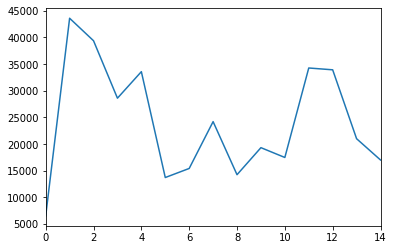

14-year mean: 24138.67
14-year standard deviation: 10450.88


In [7]:
sat_hist = a1['Saturday Attendance'].copy()
sat_hist.plot()
pyplot.show()
print('14-year mean: ' + str(round(numpy.mean(sat_hist.tolist()),2)))
print('14-year standard deviation: ' + str(round(numpy.std(sat_hist.tolist()),2)))

Okay, so we can now see that Saturday attendance varies pretty wildly each year. If only we could use auxilliary data to investigate these changes...

We'll first split the dataset into training and testing sets to minimize forward leakage of information:

In [8]:
from sklearn.model_selection import train_test_split

test_prop = 0.3
test_size = int(round(test_prop * len(sat_hist), 0))

train, test = train_test_split(sat_hist,
                               test_size = test_prop,
                               shuffle = False)

# Adjustment for rounding error
if test_size < len(test):
    test_size = len(test)

Next, we will simulate Saturday's attendance over 1000 iterations, using the calculated mean and std dev of the training set:

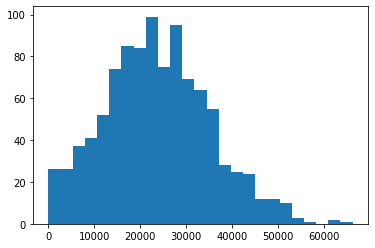

[17470 34250 33910 20990 17000]


In [9]:
result = []

sim = 1000
attendance = train.iloc[-1]
train_mu = numpy.mean(train)
train_sigma = numpy.std(train)

for i in range(0,sim):
    ann_sat_att = max(np.random.normal(train_mu,train_sigma,1)[0], 0)
    result.append(ann_sat_att)
    
plt.hist(result, bins = 25)
plt.show()
print(array(test))

Given the 10 year mean and std. dev. of Saturday attendance, here's what the distribution looks like. When we compare that distribution to the last 5 years of attendance, it looks like the attendance numbers for the last 5 years fall within 1 SD of our distribution.

Next, we'll forecast this year's Saturday attendance using historical data. Given that we're only using past years' attendance to forecast this year's, we'll be doing it graphically. 

Drift method

Credit: Dan Trepanier, _1.1 Forecast Lecture_

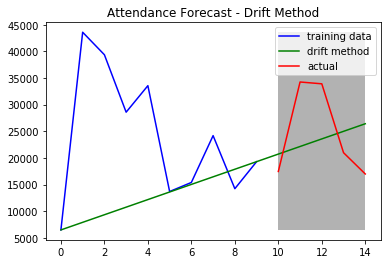

In [10]:
Y = np.array(train.tolist())
X = np.array(range(len(Y)))
Y_act = np.array(test.tolist()[:test_size])

# y = m * x + b
m = (Y[-1] - Y[0]) / (X[-1] - X[0])
b = Y[0]

X_hat = np.array(range(len(Y) + test_size))
Y_hat = m * X_hat + b

Y_all = np.concatenate((Y,Y_act), axis=0)
drift = round(m * (len(Y_all) + 1) + b, 0)

(low,high) = (min(Y_all), max(Y_all))
(left, right) = (max(X) + 1, max(X_hat) + 1)

plt.plot(X,Y, color='b', label='training data')
plt.plot(X_hat, Y_hat, color='g', label='drift method')
plt.plot(X_hat[-test_size:], Y_act,color='r', label='actual')
plt.fill_between(range(left,right), low,high, facecolor='k', alpha=.3)
plt.legend()
plt.title('Attendance Forecast - Drift Method')
plt.show()

Log Regression Method

Credit: Dan Trepanier, _1.1 Forecast Lecture_

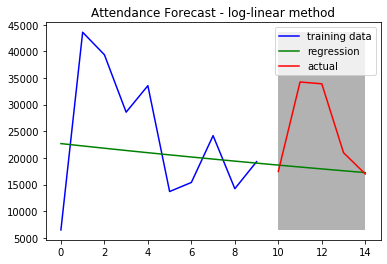

In [11]:
from scipy import stats

Y_train_log = np.log(train)
X_train = np.array(range(len(Y_train_log)))

# y = m * x + b
(m, b, r_value, p_value, std_err) = stats.linregress(X_train,Y_train_log)

X_hat = np.array(range(len(Y_train_log) + test_size))
Y_log_hat = m * X_hat + b
Y_act_log = np.log(test[:test_size])

Y_all = np.concatenate((Y_train_log,Y_act_log), axis=0)
(low_log,high_log) = (min(log(Y_all)), max(log(Y_all)))
(left, right) = (max(X) + 1, max(X_hat) + 1)

Y_hat = np.exp(Y_log_hat)
loglinear = round(exp(m * (len(Y_all) + 1) + b),0)

plt.plot(X,Y, color='b', label='training data')
plt.plot(X_hat, Y_hat, color='g', label='regression')
plt.plot(X_hat[-test_size:], Y_act, color='r', label='actual')
plt.fill_between(range(left,right), low, high, facecolor='k', alpha=.3)
plt.legend()
plt.title('Attendance Forecast - log-linear method')
plt.show()

In [12]:
drift_sim = []
loglin_sim = []

for i in range(1000):
    drift_sim.append(max(np.random.normal(drift, train_sigma, size = 1)[0],0))
    loglin_sim.append(max(np.random.normal(loglinear, train_sigma, size = 1)[0],0))
    
print(round(np.mean(drift_sim),2), round(np.mean(loglin_sim),2))

29303.26 16910.92


Below is a histogram summarizing Saturday's attendance using the drift method:

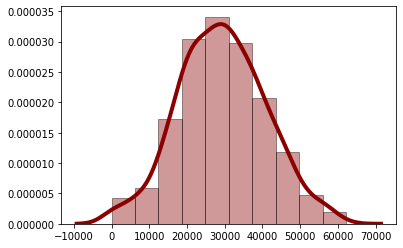

In [13]:
sns.distplot(drift_sim, hist=True, kde=True, 
             bins = 10, color = 'darkred', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.show()

And again, but using the log-linear method:

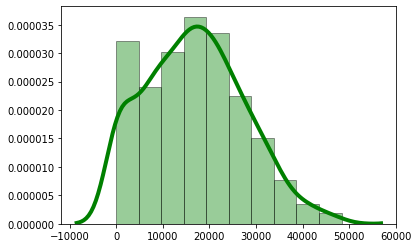

In [14]:
sns.distplot(loglin_sim, hist=True, kde=True, 
             bins = 10, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.show()

In [15]:
ranj = drift, loglinear

print('Attendance for this year\'s festival will range between ' +\
     str(min(ranj)) + ' and ' + str(max(ranj)) + ' attendees.')

Attendance for this year's festival will range between 16599.0 and 29266.0 attendees.


__Q3 It's hip to be square (with everyone else)__

Probability distribution of historical attendance

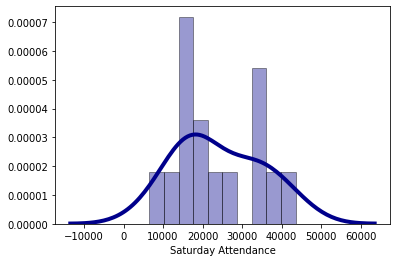

In [16]:
sns.distplot(sat_hist, hist=True, kde=True, 
             bins = 10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.show()

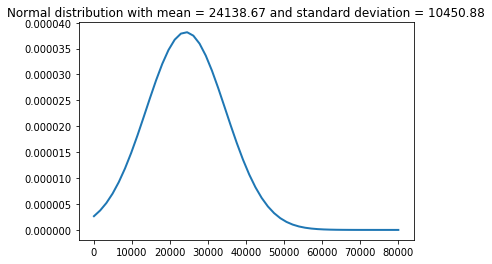

In [17]:
from scipy.stats import norm
mean = round(numpy.mean(sat_hist),2)
standard_deviation = round(numpy.std(sat_hist),2)
normal_distribution = norm(loc = mean, scale = standard_deviation)
x = numpy.linspace(0, 80000)
_, ax = plt.subplots(1, 1)
ax.plot(x, normal_distribution.pdf(x), '-', lw = 2)
plt.title('Normal distribution with mean = ' + str(mean) +\
          ' and standard deviation = ' + str(standard_deviation))
plt.show()

Given that we know the sample size of n = 37, the sample mean of 18.92%, and population standard deviation of 39.17%, we can derive the sample standard deviation using the formula below:

\begin{equation*}
\sigma_M = \frac{\sigma} {\sqrt{n}}
\end{equation*}

In [18]:
def sample_sigma(n = 1, sigma = 0):
    s_sigma = None
    assert n > 0
    assert sigma >= 0
    try:
        s_sigma = sigma / sqrt(n)
        return round(s_sigma,4)
    except:
        print('WRONG!')

In [19]:
s_sigma = sample_sigma(37, 0.3917)
print('Sample standard deviation for given sample size: ' + str(s_sigma))

Sample standard deviation for given sample size: 0.0644


__Q4 Who'll stop the rain?__

In [20]:
# Initial data load
y = b1['Saturday Attendance'].tolist()
X = b1.iloc[:,1:-1].values.tolist()

X_train, X_test,\
y_train, y_test = train_test_split(X, y, test_size = test_size,
                                   random_state=42,
                                   shuffle = False)

Credit: Sanjiv Das, _6 Linear Regression_

In [21]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS as linear
import statsmodels.formula.api as smf
from statsmodels.compat import lzip

X_hat = sm.add_constant(X_train, prepend=True)
results = linear(y_train, X_hat).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     37.19
Date:                Mon, 14 Oct 2019   Prob (F-statistic):           0.000285
Time:                        19:52:07   Log-Likelihood:                -92.859
No. Observations:                  10   AIC:                             193.7
Df Residuals:                       6   BIC:                             194.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3913.9936   4124.879      0.949      0.3

C:\Users\mohdh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


Before we get ahead of ourselves, let's dive into some residual diagnostics:

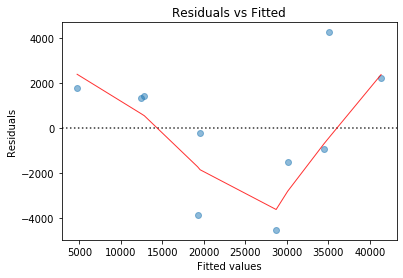

In [22]:
model_fitted_y = results.fittedvalues
model_resid = results.resid
model_norm_resid = results.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_resid))
model_abs_resid = np.abs(model_resid)
model_leverage = results.get_influence().hat_matrix_diag
model_cooks = results.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, sat_hist.iloc[:10], data = sat_hist,
                          lowess = True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
                                    
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

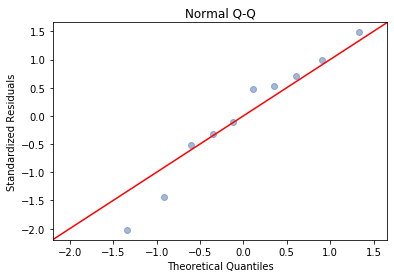

In [23]:
from statsmodels.graphics.gofplots import ProbPlot

QQ = ProbPlot(model_norm_resid)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_resid)), 0)

Given that we only have 10 data points to fit our model on, it's unsurprising the residual plots look as wild as they are. 

On Saturday afternoon, we're given new facts:<br><br>

Friday attendance: 18934<br>
Friday rain: No<br>

We can now use these numbers to simulate Saturday's attendance by fitting these values on the coefficients produced by the model above.<br><br>

To do this, we will also have to simulate the probability of rain on Saturday, given that the forecast for rain that day is 80%:

Rain

In [44]:
a + b_0 * 0 + b_1 * 18934 + b_2 * 1

18704.868987067905

No Rain

In [45]:
a + b_0 * 0 + b_1 * 18934 + b_2 * 0

27144.933460262357

Purple Rain

In [59]:
rain = []
fri_att = 18394
fri_rain = 0
a = results.params[0]
b_0 = results.params[1]
b_1 = results.params[2]
b_2 = results.params[3]

for i in range(0,1000):
    p_rain = np.random.normal(0.8, sqrt(0.8*0.2),1)[0]
    
    if p_rain >= 1:
        p_rain = 1  # Either rain or no rain
        res = a + b_0 * fri_rain + b_1 * fri_att + b_2 * p_rain
        rain.append(res)
    else:
        p_rain = 0
        res = a + b_0 * fri_rain + b_1 * fri_att + b_2 * p_rain
        rain.append(res)

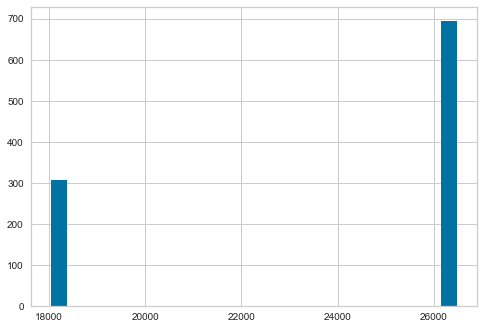

In [60]:
plt.hist(rain,bins = 25)
plt.show()

In [58]:
np.mean(rain)

23899.72448033022

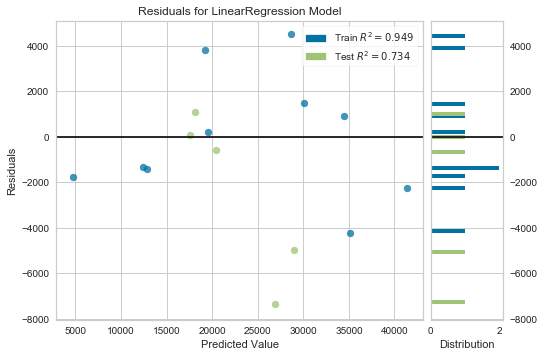

In [26]:
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression

model = LinearRegression()

visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure
plt.show()

__Q5 Profit simulations__

Next, we'll simulate the distribution of profits under uncertainty of rain, Saturday attendance, and variability in an individual purchasing DVDs.

In [27]:
####
# Input: DVDs to be produced, n sim iterations, prop. of attendees purchasing DVDs,
#         associated std dev, array of simulated attendance numbers
# 
# Output: array of simulated profits over n iterations.
####
def simulate_profits(dvd_produced, n, mu, sigma, attendance_sim):
    assert dvd_produced > 0
    
    try:
        demand_sim = []
        profits = []
        attendance = []
        (lower, upper) = mu - sigma, mu + sigma
        in_range = []
        supply_rec = []

        for i in range(n):
            sat_att_sim = max(np.random.choice(attendance_sim), 0)
            #sat_att_sim = attendance_sim
            mu_sim = max(np.random.normal(mu, sigma), 0)
            if (mu_sim > lower) & (mu_sim < upper):
                in_range.append(1)
            else:
                in_range.append(0)
                                   
            demand_res = sat_att_sim * mu_sim
            demand_sim.append(demand_res)
            profits.append(p_l_calculate(demand_res, dvd_produced))
            attendance.append(sat_att_sim)
            supply_rec.append(dvd_produced)
            
        rec = list(zip(demand_sim, supply_rec, attendance, profits, in_range))

        plt.hist(profits, bins = 50)
        return rec
    
    except:
        print('Profit simulation failed.')
    
    return None

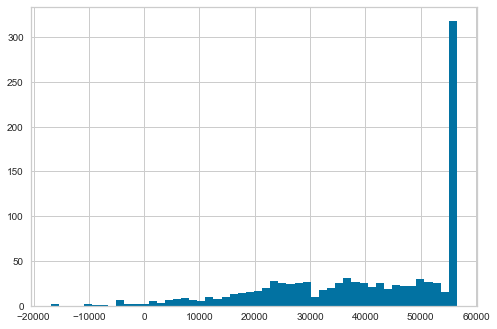

In [28]:
money = simulate_profits(4500, 1000, 0.1892, s_sigma, rain)

In [29]:
profit_df = pd.DataFrame(money, columns = ['Act Dd', 'Act Ss', 'Attn', 'Profits', 'In Range'])

In [30]:
profit_df['Loss'] = profit_df['Profits'] < 0
loss_prop = profit_df['Loss'].sum() / len(profit_df) * 100
print('Under the current risk profile, if 4500 DVDs are produced, the team ' +\
     'can expect to make losses only ' + str(loss_prop) + '% of the time.')

Under the current risk profile, if 4500 DVDs are produced, the team can expect to make losses only 1.7999999999999998% of the time.


__Q6 Grab that cash with both hands and make a stash__

In [31]:
sim_mean = profit_df['Act Dd'].mean()

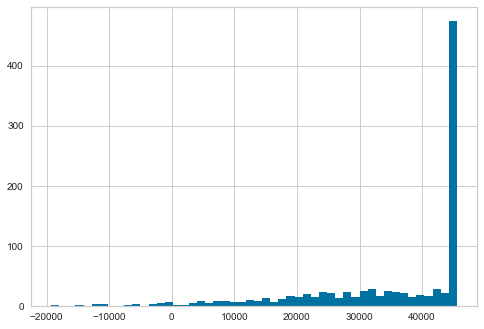

In [32]:
money = simulate_profits(sim_mean, 1000, 0.1892, s_sigma, rain)

In [33]:
test_df_2 = pd.DataFrame(money, columns = ['Act Dd', 'Act Ss', 'Attn', 'Profits', 'In Range'])

In [34]:
test_df_2['Loss'] = test_df_2['Profits'] < 0
loss_rate = test_df_2['Loss'].sum() / len(test_df_2) * 100

In [35]:
print('By producing ' + str(int(round(sim_mean,0))) +\
     ' DVDs, Carla\'s team will be profitable with ' +\
     str(100 - loss_rate) + '% probability.')

By producing 3818 DVDs, Carla's team will be profitable with 97.5% probability.


__Q7 Value Add__

Let's simulate first simulate the P&L over 100 trials, producing up to 10000 DVDs. Just to see where the inflection point for profits would show up.

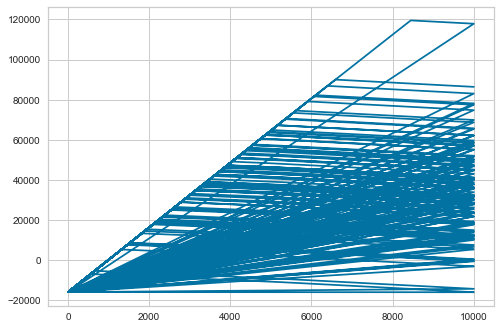

In [36]:
pi = []
dvd_made = []

for i in range(100):
    
    trial_attn = max(np.random.choice(rain), 0)
    dd_prop_sim = max(np.random.normal(0.1892, s_sigma), 0)
    trial_dd = trial_attn * dd_prop_sim

    for j in range(10000):
        dvd_ss = j + 1
        pi.append(p_l_calculate(trial_dd,dvd_ss))
        dvd_made.append(dvd_ss)

rec = list(zip(dvd_made,pi))
    
plt.plot(dvd_made, pi)
plt.show()   

Well, that was fun. From the graph, we can't really tell clearly where the average breakeven point lies.

__Value Add__

- Perhaps Carla Monte can add value to this project by attempting to negotiate the price per additional unit of DVDs to be a few cents cheaper.
    - If I had more time, I would run the simulation again with varying discounts on the additional per unit cost (ranging between 5c to 10c less)
- Carla's team can take a proactive approach by deciding how to sell the DVDs to the attendees. They need to consider when during the event are people most likely to purchase the DVDs, and where. Then they can decide how to setup and distribute the DVDs for easy purchase by the attendees.

__Recommendations__

- Carla Monte should invest in the producing the DVDs.
- The team should produce ~ 3650 copies of DVDs to sell on Saturday.
    - This will maximize profits as wasted DVDs are minimized.
- Probability of losses are low - will breakeven with 97.7% probability.